In this notebook I did sentiment analysis on tweeter dataset. 

I designed 4 model for this purpose:
- Bi-directional LSTM
- Convolutional Nural Network
- Logistic Regression
- Baysian Classifier

For Deep Learning models I used Word Embedding Keras layer for feature extraction and for classic models I used CountVectorize and TF-IDF.

At the end I concluded that Bi-LSTM layer hast better performance for this dataset.

## Load Data from kaggle

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nargesfarrokhshad","key":"931a00b3b807f9df8b1fcf339dbd9d5a"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d "anmolkumar/glove-embeddings/glove.6B.100d.txt"

 99% 833M/844M [00:21<00:00, 42.5MB/s]
100% 844M/844M [00:22<00:00, 40.2MB/s]


In [ ]:
!kaggle datasets download -d "kazanova/sentiment140"

 70% 57.0M/80.9M [00:01<00:00, 25.7MB/s]
100% 80.9M/80.9M [00:02<00:00, 42.0MB/s]


In [ ]:
! unzip "/content/sentiment140.zip"

Archive:  /content/sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
! unzip "/content/glove-embeddings.zip"

Archive:  /content/glove-embeddings.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
  inflating: glove.6B.50d.txt        


## Import necessary liberaries

In [ ]:
import pandas as pd
#pandas
import numpy as np
#numpy
import matplotlib.pyplot as plt
#matplotlib
import seaborn as sns
#seaborn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#sklearn
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM,Layer,Bidirectional
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from keras.optimizers import Adam
#keras
import tensorflow as tf
#tensorflow
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#nltk
import re
import os
#other useful stuff
from wordcloud import WordCloud, STOPWORDS
#wordclouds and cloud stopwords
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv",encoding = 'latin',header=None)

FileNotFoundError: ignored

In [ ]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.shape

(1600000, 6)

 Columns refere to:
- 0 - target of sentiment 
- 1 - id of user
- 2 - date of tweet
- 3 - unnecessary column, in each row contains 'NO_QUERY'
- 4 - nickname of author
- 5 - content of tweet

In [ ]:
data = df.rename(columns={0: 'label', 1: 'id', 2: 'date', 3: 'query', 4: 'username', 5: 'tweet'})

In [ ]:
data.isnull().sum()

label       0
id          0
date        0
query       0
username    0
tweet       0
dtype: int64

Fortunately, there isn't any missing value.

## Some Analysis of tweets

target=0 refers to negative tweets

In [ ]:
pd.set_option('display.max_colwidth', -1)
data[data['label']==0]['tweet'].head()

0    @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
1    is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    
2    @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                          
3    my whole body feels itchy and like its on fire                                                                     
4    @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.     
Name: tweet, dtype: object

target=4 refers to positive tweets

In [ ]:
data[data['label']==4]['tweet'].head

<bound method NDFrame.head of 800000     I LOVE @Health4UandPets u guys r the best!!                                                                                              
800001     im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!                                                                 
800002     @DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart. 
800003     Being sick can be really cheap when it hurts too much to eat real food  Plus, your friends make you soup                                 
800004     @LovesBrooklyn2 he has that effect on everyone                                                                                           
                                ...                                                                                                                 
1599995    Just woke up. Having no school is the best feeling ever          

In [ ]:
data['label'] = data['label'].replace([0, 4],['Negative','Positive'])

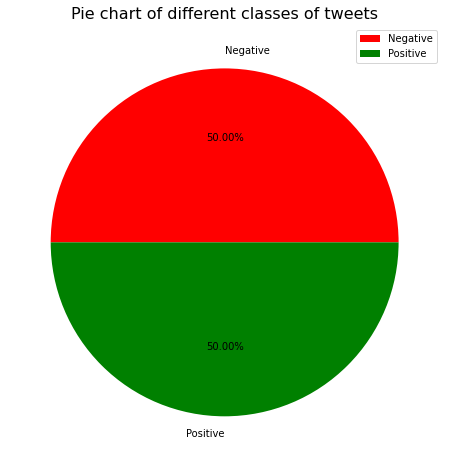

In [ ]:
fig = plt.figure(figsize=(8,8))
targets = data.groupby('label').size()
targets.plot(kind='pie', subplots=True, figsize=(10, 8), autopct = "%.2f%%", colors=['red','green'])
plt.title("Pie chart of different classes of tweets",fontsize=16)
plt.ylabel("")
plt.legend()
plt.show()

dataset is perfectly balanced

Word Cloud for positive sentiment tweets

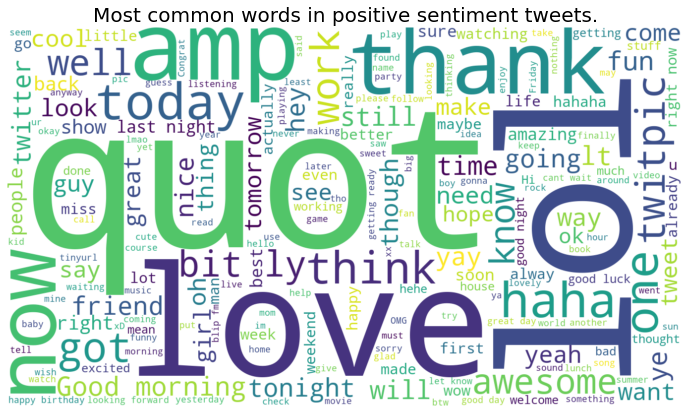

In [ ]:
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, width=1366, height=768, background_color="white").generate(" ".join(data[data.label=='Positive'].tweet))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in positive sentiment tweets.',fontsize=20)
plt.show()

Word Cloud for negative sentiment tweets

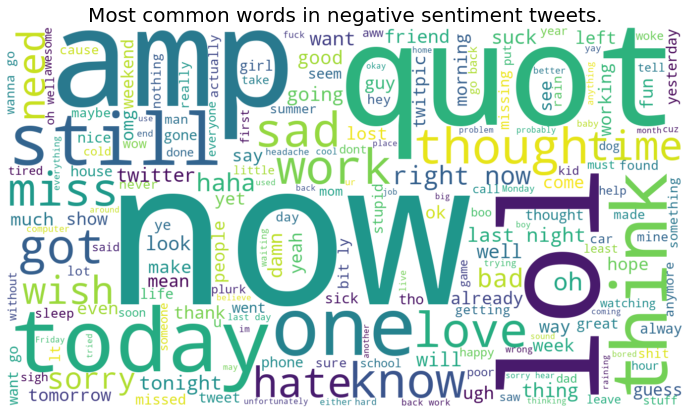

In [ ]:
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, max_words = 200, width=1366, height=768, background_color="white").generate(" ".join(data[data.label=='Negative'].tweet))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in negative sentiment tweets.',fontsize=20)
plt.show()

## Preprocessing

In [ ]:
data.drop(['id','date','query','username'], axis=1, inplace=True)
data.label = data.label.replace({'Positive': 1, 'Negative': 0})
data.head()

,label,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
#base of english stopwords
english_stopwords = stopwords.words('english')
#stemming algorithm
stemmer = SnowballStemmer('english')
#regex for mentions and links in tweets
regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [ ]:
def preprocess(content, stem=False):
  content = re.sub(regex, ' ', str(content).lower()).strip()
  tokens = []
  for token in content.split():
    if token not in english_stopwords:
      tokens.append(stemmer.stem(token))
  return " ".join(tokens)

In [ ]:
data.tweet = data.tweet.apply(lambda x: preprocess(x))

In [ ]:
data.to_csv('/content/processed_tweets.csv')

In [ ]:
data.head()

,label,tweet
0,0,awww bummer shoulda got david carr third day
1,0,upset updat facebook text might cri result school today also blah
2,0,dive mani time ball manag save 50 rest go bound
3,0,whole bodi feel itchi like fire
4,0,behav mad see


Split train and test dataset

In [ ]:
train, test = train_test_split(data, test_size=0.1, random_state=44)
print('Train dataset shape: {}'.format(train.shape))
print('Test dataset shape: {}'.format(test.shape))

Train dataset shape: (1440000, 2)
Test dataset shape: (160000, 2)


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.tweet)  
vocab_size = len(tokenizer.word_index) + 1 
max_length = 50

In [ ]:
sequences_train = tokenizer.texts_to_sequences(train.tweet) 
sequences_test = tokenizer.texts_to_sequences(test.tweet) 

X_train = pad_sequences(sequences_train, maxlen=max_length, padding='post')
X_test = pad_sequences(sequences_test, maxlen=max_length, padding='post')

y_train = train.label.values
y_test = test.label.values

## Bi-Directional LSTM model

Feature extraction using pretrained glove-100

In [ ]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('/content/glove.6B.100d.txt')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
    
glove_file.close()

embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector

model parameteres

In [ ]:
num_epochs = 10
batch_size = 1000

In [ ]:
LSTM_model = Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Bidirectional(LSTM(64, return_sequences=True)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Bidirectional(LSTM(128)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
LSTM_model.summary()


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 50, 100)           26901500  
_________________________________________________________________
bidirectional_54 (Bidirectio (None, 50, 128)           84480     
_________________________________________________________________
dropout_58 (Dropout)         (None, 50, 128)           0         
_________________________________________________________________
bidirectional_55 (Bidirectio (None, 256)               263168    
_________________________________________________________________
dropout_59 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_43 (Dense)             (None, 1)               

In [ ]:
LSTM_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5),
              ModelCheckpoint(filepath='weights.best.hdf5',save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)]

history = LSTM_model.fit(X_train, y_train, batch_size = batch_size, epochs=num_epochs,validation_split=0.1,callbacks=callbacks, verbose=2)

Epoch 1/10
1296/1296 - 70s - loss: 0.4661 - accuracy: 0.7747 - val_loss: 0.4786 - val_accuracy: 0.7660
Epoch 2/10
1296/1296 - 65s - loss: 0.4622 - accuracy: 0.7773 - val_loss: 0.4778 - val_accuracy: 0.7667
Epoch 3/10
1296/1296 - 64s - loss: 0.4591 - accuracy: 0.7790 - val_loss: 0.4792 - val_accuracy: 0.7673
Epoch 4/10
1296/1296 - 64s - loss: 0.4568 - accuracy: 0.7803 - val_loss: 0.4811 - val_accuracy: 0.7661
Epoch 5/10
1296/1296 - 64s - loss: 0.4543 - accuracy: 0.7817 - val_loss: 0.4784 - val_accuracy: 0.7668
Epoch 6/10
1296/1296 - 64s - loss: 0.4523 - accuracy: 0.7834 - val_loss: 0.4810 - val_accuracy: 0.7659
Epoch 7/10
1296/1296 - 64s - loss: 0.4499 - accuracy: 0.7846 - val_loss: 0.4799 - val_accuracy: 0.7659
Epoch 8/10
1296/1296 - 64s - loss: 0.4432 - accuracy: 0.7886 - val_loss: 0.4813 - val_accuracy: 0.7665


In [ ]:
y_pred = LSTM_model.predict(X_test)
y_pred = np.where(y_pred>0.5, 1, 0)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.75      0.76     79800
           1       0.76      0.78      0.77     80200

    accuracy                           0.77    160000
   macro avg       0.77      0.77      0.77    160000
weighted avg       0.77      0.77      0.77    160000



In [ ]:
#History for accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='lower right')
plt.show()
# History for loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.suptitle('Accuracy and loss for second model')
plt.show()

In [ ]:
LSTM_model.save('/content/drive/MyDrive/nlp_digikala/tweetAnalysis.h5')

## CNN Model

In [ ]:
CNN_model = Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
        tf.keras.layers.Conv1D(32,3,activation='relu'),
        tf.keras.layers.MaxPooling1D(3),
        tf.keras.layers.Conv1D(64,3,activation='relu'),
        tf.keras.layers.MaxPooling1D(3),
        tf.keras.layers.Conv1D(128,3,activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

CNN_model.summary()

CNN_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
history2 = CNN_model.fit(X_train, y_train, batch_size = batch_size, epochs=10, validation_split=0.1,callbacks=callbacks, verbose=2)


Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 50, 100)           26901500  
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 48, 32)            9632      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 16, 32)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 14, 64)            6208      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 2, 128)            24704     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)             

In [ ]:
y_pred = CNN_model.predict(X_test)
y_pred = np.where(y_pred>0.5, 1, 0)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74     79800
           1       0.74      0.77      0.75     80200

    accuracy                           0.75    160000
   macro avg       0.75      0.75      0.75    160000
weighted avg       0.75      0.75      0.75    160000



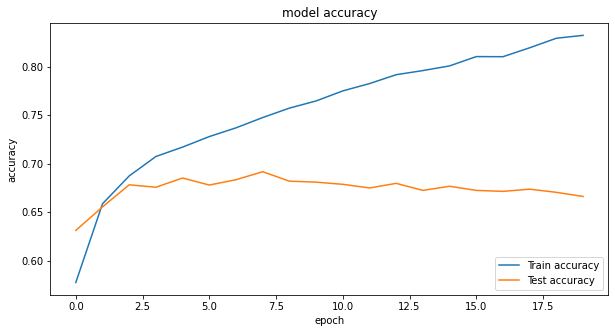

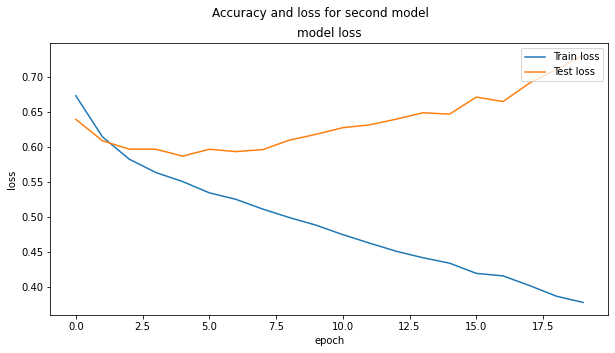

In [ ]:
#History for accuracy
plt.figure(figsize=(10,5))
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='lower right')
plt.show()
# History for loss
plt.figure(figsize=(10,5))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.suptitle('Accuracy and loss for second model')
plt.show()

## Logistic Regression Model

Feature extraction using CountVectorize

In [ ]:
data = pd.read_csv('processed_tweets.csv',index_col=False)

data = data.dropna()

# sampling

# data1 = data[:10000]
# data2 = data.tail(10000)
# data = pd.concat([data1,data2])

data.shape

(20000, 3)

In [ ]:
vectorizer = CountVectorizer(ngram_range =(1,3), 
                            analyzer="word",
                            preprocessor=None,
                            stop_words="english",
                            max_features=10000)

In [ ]:
tweets = data.tweet.tolist()

In [ ]:
data.head()

,Unnamed: 0,label,tweet
0,0,0,awww bummer shoulda got david carr third day
1,1,0,upset updat facebook text might cri result sch...
2,2,0,dive mani time ball manag save 50 rest go bound
3,3,0,whole bodi feel itchi like fire
4,4,0,behav mad see


In [ ]:
X = vectorizer.fit_transform(tweets).toarray()
y = data.label

In [ ]:
print (X.shape) 
print (y.shape) 

(20000, 10000)
(20000,)


In [ ]:
vocab = vectorizer.get_feature_names()
len(vocab)

10000

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=123)

In [ ]:
logisticRegr = LogisticRegression(C=0.27, solver='liblinear', max_iter = 1000)
logisticRegr.fit(x_train, y_train)

LogisticRegression(C=0.27, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predict = logisticRegr.predict(x_test)

cm = confusion_matrix(predict,y_test)
cm

array([[1406,  474],
       [ 579, 1541]])

In [ ]:
accuracy = accuracy_score(y_test, predict)
accuracy

0.73675

Feature extraction using tfidf

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range =(1,3),
                                   stop_words='english',
                                   min_df=0.0005,
                                   max_features=10000)
X0 = tfidf_vectorizer.fit_transform(tweets).toarray()
y0 = data.label

In [ ]:
vocab0 = tfidf_vectorizer.get_feature_names()
len(vocab0)

1990

In [ ]:
x0_train, x0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.2,random_state=123)

In [ ]:
logisticRegr.fit(x0_train, y0_train)

LogisticRegression(C=0.27, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
predict0 = logisticRegr.predict(x0_test)

cm = confusion_matrix(predict0, y0_test)
cm

array([[1420,  506],
       [ 565, 1509]])

In [ ]:
accuracy = accuracy_score(y0_test, predict0)
accuracy

0.73225

## Bayes Classifier Model

Feature extraction using CountVectorize

In [ ]:
classifier = BernoulliNB()
classifier.fit(x_train, y_train)

# Predict Class
y_pred = classifier.predict(x_test)

# Accuracy 
accuracy1 = accuracy_score(y_test, y_pred)
accuracy1

0.7325

Feature extraction using tf-idf

In [ ]:
classifier.fit(x0_train, y0_train)

# Predict Class
y0_pred = classifier.predict(x0_test)

# Accuracy 
accuracy1 = accuracy_score(y0_test, y0_pred)
accuracy1

0.7335

In [ ]:
cm1 = confusion_matrix(y0_pred,y0_test)
cm1

array([[1431,  512],
       [ 554, 1503]])

## Coclusion

| Model | Accuracy |
| ---   | --- |
| Bi-LSTM | .77 |
| CNN | .75|
| Logistic Regression| .736 |
| Baysian | .733 |


As a result Bi-LSTM is best model for sentiment analysis of this dataset